In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.autograd import grad
from torch import nn, optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torch.optim.lr_scheduler import MultiStepLR
from torchvision.utils import make_grid
from torchvision import transforms as torch_transforms

In [6]:
import sys
sys.path.append("./../../")

from modules.dvae.model import DVAE
from modules.transformer_gen.ar_uncond.generator import LatentGenerator
from datasets.mnist_loader import MNISTData
from notebooks.utils import show

In [12]:
class Config:
    DEVICE                      = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    img_channels                = 1
    vocab_size                  = 32
    
    hidden_height               = 7
    hidden_width                = 7

    num_blocks                  = 10
    n_attn_heads                = 8
    hidden_dim                  = 256
    dropout_prob                = 0.1

    dvae_num_x2upsamples        = 2
    dvae_num_resids_downsample  = 3
    dvae_num_resids_bottleneck  = 4
    dvae_hidden_dim             = 256

    mnist_type                  = "classic"
    root_img_path               = "/m/home/home8/82/sukhoba1/data/Desktop/TA-VQVAE/data/MNIST/"
    
    dvae_model_path             = "/m/home/home8/82/sukhoba1/data/Desktop/TA-VQVAE/models/mnist/dvae_vocab32_mnist/"
    dvae_model_name             = "dvae_vocab32_mnist"
    
    model_path                  = "/m/home/home8/82/sukhoba1/data/Desktop/TA-VQVAE/models/mnist/tr/ar_uncond/"
    model_name                  = "latent_gen"
    
    NUM_EPOCHS                  = 50
    BATCH_SIZE                  = 512
    LR                          = 0.01
    LR_gamma                    = 0.1
    step_LR_milestones          = [5, 15, 25]


CONFIG = Config()

In [13]:
data_source = MNISTData(
    img_type=CONFIG.mnist_type,
    root_path=CONFIG.root_img_path,
    batch_size=CONFIG.BATCH_SIZE)
train_loader = data_source.get_train_loader()

In [14]:
dvae = DVAE(
    in_channels=CONFIG.img_channels,
    vocab_size=CONFIG.vocab_size,
    num_x2downsamples=CONFIG.dvae_num_x2upsamples,
    num_resids_downsample=CONFIG.dvae_num_resids_downsample,
    num_resids_bottleneck=CONFIG.dvae_num_resids_bottleneck,
    hidden_dim=CONFIG.dvae_hidden_dim,
    device=CONFIG.DEVICE)

G = LatentGenerator(
    hidden_width=CONFIG.hidden_width,
    hidden_height=CONFIG.hidden_height,
    embedding_dim=CONFIG.vocab_size,
    num_blocks=CONFIG.num_blocks,
    hidden_dim=CONFIG.hidden_dim,
    n_attn_heads=CONFIG.n_attn_heads,
    dropout_prob=CONFIG.dropout_prob,
    device=CONFIG.DEVICE)

optimizer = optim.Adam(G.parameters(), lr=CONFIG.LR)

lr_scheduler = MultiStepLR(optimizer, milestones=CONFIG.step_LR_milestones, gamma=CONFIG.LR_gamma)

In [15]:
dvae.eval()
G.train()

dvae.load_model(
    root_path=CONFIG.dvae_model_path,
    model_name=CONFIG.dvae_model_name)

In [20]:
print("Device in use: {}".format(CONFIG.DEVICE))

criteriation = nn.CrossEntropyLoss()

iteration = 0
for epoch in range(5):
    for img, label in train_loader:
        img = img.to(CONFIG.DEVICE)

        with torch.no_grad():
            latent = dvae.ng_q_encode(img)

        b, emb, h, w = latent.size()
        x = latent.view(b, emb, -1).permute(2, 0, 1)
        
        start_vector = torch.zeros(1, b, emb, device=x.device)
        x_strat_seq = torch.cat([start_vector, x[:-1,:,:]], dim=0)
        x_end_seq = x
        
        output = G(x_strat_seq)
        
        labels_pred = output.view(-1, emb)
        lables_true = x_end_seq.argmax(dim=2).view(-1)
        
        loss = criteriation(labels_pred, lables_true)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        iteration += 1

    if epoch % 5 == 0:
        print("Epoch: {} Loss: {}".format(epoch, round(loss.item(), 5)))
    
    lr_scheduler.step()
    

Device in use: cuda
Epoch: 0 Loss: 1.22904


In [23]:
G.save_model(root_path=CONFIG.model_path, model_name=CONFIG.model_name)

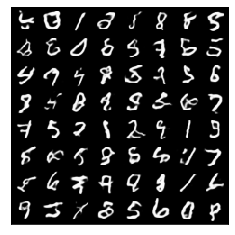

In [21]:
samples = G.sample(n_samples=64)

latent_x = samples.view(CONFIG.hidden_height, CONFIG.hidden_width, 64, CONFIG.vocab_size).permute(2, 3, 0, 1)

with torch.no_grad():
    gen_img = dvae.decode(latent_x)

show(gen_img)